# Imports

In [2]:
import numpy as np
import pandas as pd
import uproot
import awkward as ak

import tqdm
import matplotlib.pyplot as plt

import dimod
from dwave.samplers import SimulatedAnnealingSampler

from src.draw_decay_chain import draw_decay_chain
from src.root_to_numpy import root_to_numpy
from src.create_pair_mapping import create_pair_mapping
from src.build_pair_masses import build_pair_masses

# Global Variables

In [3]:
ROOT_FILE = "data/HHH.root"

NUM_EVENTS = 10000  # or None for all
HIGGS_MASS = 125    # GeV;

# Dataframes

## Load Dataframes from ROOT
These are **jagged NumPy arrays**, meaning they are NumPy arrays with dtype=object, where each element is itself a NumPy array of variable length.

This differs from standard (rectangular) NumPy ndarrays, which are contiguous, fixed-shape numeric tensors where all rows have the same length.

In [4]:
data = root_to_numpy(ROOT_FILE, num_events=NUM_EVENTS)

nGenJet = data["nGenJet"]

GenJet_pt = data["GenJet_pt"]
GenJet_eta = data["GenJet_eta"]
GenJet_phi = data["GenJet_phi"]
GenJet_mass = data["GenJet_mass"]

GenJet_partonFlavour = data["GenJet_partonFlavour"]
GenJet_hadronFlavour = data["GenJet_hadronFlavour"]

nGenPart = data["nGenPart"]

GenPart_pt = data["GenPart_pt"]
GenPart_eta = data["GenPart_eta"]
GenPart_phi = data["GenPart_phi"]
GenPart_mass = data["GenPart_mass"]

GenPart_pdgId = data["GenPart_pdgId"]
GenPart_genPartIdxMother = data["GenPart_genPartIdxMother"]
GenPart_status = data["GenPart_status"]
GenPart_statusFlags = data["GenPart_statusFlags"]


## Examine Dataframes

### Check Gen-level Higgs masses
We check the masses of all Higgs bosons (pdgID-25) with Status-62 (last copy before decay), and name event "invalid" if any of 3H has mass different from `HIGGS_MASS` (125 GeV).

Mean mass: 125.0 GeV
Standard deviation: 0.0 GeV
Invalid events: 0/10000
Invalid event indices: []
Invalid masses: []


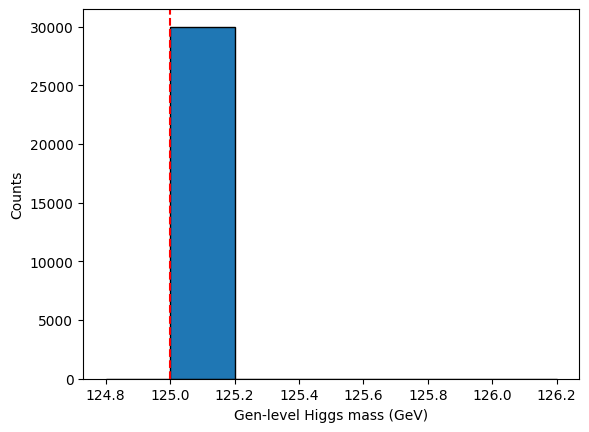

In [5]:
masses = []
invalid_masses = []
invalid_events_masses = []

for event in range(NUM_EVENTS):

    # select masses with status 62
    mask = (GenPart_pdgId[event] == 25) & (GenPart_status[event] == 62)
    event_masses = GenPart_mass[event][mask]

    # find invalid ones in event (use tolerance for floats!)
    mask_invalid = np.abs(event_masses - HIGGS_MASS) > 1e-3

    if np.any(mask_invalid):
        invalid_events_masses.append(event)
        invalid_masses.extend(event_masses[mask_invalid])

    masses.extend(event_masses)

# convert to numpy at end
masses = np.array(masses)
invalid_masses = np.array(invalid_masses)
invalid_events_masses = np.array(invalid_events_masses)


print(f'Mean mass: {np.mean(masses)} GeV')
print(f'Standard deviation: {np.std(masses)} GeV')
print(f'Invalid events: {len(invalid_events_masses)}/{NUM_EVENTS}')
print(f'Invalid event indices: {invalid_events_masses}')
print(f'Invalid masses: {invalid_masses}')

bin_width = 0.2

bins = np.arange(
    HIGGS_MASS - bin_width,
    HIGGS_MASS + bin_width + 1,
    bin_width
)

plt.hist(masses, bins=bins, edgecolor='black')
plt.axvline(HIGGS_MASS, color='red', linestyle='--')
plt.xlabel("Gen-level Higgs mass (GeV)")
plt.ylabel("Counts")
plt.show()

### Check Gen-level B-tagged jets
For each event, we check how many Gen-level jets are identified as b-jets (by `GenJet_hadronFlavour == 5`).

Mean b-tagged jets: 5.473
Standard deviation: 0.7378827820189329
Invalid events: 4624/10000
Invalid events: [   3    4    5 ... 9993 9997 9998]
Invalid numbers: [5 5 4 ... 5 5 4]


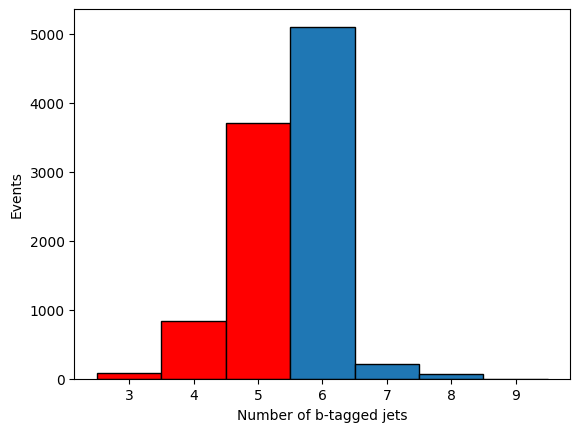

In [6]:
num_b_tagged_jets = []
for event in range(NUM_EVENTS):
    count = np.sum(np.abs(GenJet_hadronFlavour[event]) == 5)
    num_b_tagged_jets.append(count)

num_b_tagged_jets = np.array(num_b_tagged_jets)

mask_invalid = num_b_tagged_jets < 6

invalid_events_b_jets = np.where(mask_invalid)[0]
invalid_number = num_b_tagged_jets[mask_invalid]

print(f'Mean b-tagged jets: {np.mean(num_b_tagged_jets)}')
print(f'Standard deviation: {np.std(num_b_tagged_jets)}')
print(f'Invalid events: {len(invalid_events_b_jets)}/{NUM_EVENTS}')
print(f'Invalid events: {invalid_events_b_jets}')
print(f'Invalid numbers: {invalid_number}')


bins = np.arange(
    np.min(num_b_tagged_jets),
    np.max(num_b_tagged_jets) + 2
) - 0.5

counts, edges, patches = plt.hist(
    num_b_tagged_jets,
    bins=bins,
    edgecolor='black'
)

# Color bins where value < 6
for i, patch in enumerate(patches):
    bin_center = (edges[i] + edges[i+1]) / 2
    if bin_center < 6:
        patch.set_facecolor('red')

plt.xlabel("Number of b-tagged jets")
plt.ylabel("Events")
plt.xticks(range(np.min(num_b_tagged_jets), np.max(num_b_tagged_jets) + 1))
plt.show()


## Filter Dataframes


### Filter-out Invalid Events

1. We have indices `invalid_events_masses` of events where Higgs' masses are not equal to `HIGGS_MASS` - we consider these faulty from the simulation and remove them.
2. We have indices `invalid_events_b_jets` of events where <6 b-tagged jets exist - in these events, it is imposible to pick 3 pairs, so we remove them too.

In [7]:
invalid_events = np.int32(np.unique(np.concatenate([invalid_events_masses, invalid_events_b_jets])))
print(f'Unique invalid events to filter-out: {len(invalid_events)}/{NUM_EVENTS}')
print(f'After filtering, there should be {NUM_EVENTS - len(invalid_events)} ({(NUM_EVENTS - len(invalid_events)) / NUM_EVENTS * 100}%) of events left.')

Unique invalid events to filter-out: 4624/10000
After filtering, there should be 5376 (53.76%) of events left.


Let's filter-out invalid events:

In [8]:
event_mask = np.ones(NUM_EVENTS, dtype=bool)
event_mask[invalid_events] = False

nGenJet = nGenJet[event_mask]

GenJet_pt = GenJet_pt[event_mask]
GenJet_eta = GenJet_eta[event_mask]
GenJet_phi = GenJet_phi[event_mask]
GenJet_mass = GenJet_mass[event_mask]

GenJet_partonFlavour = GenJet_partonFlavour[event_mask]
GenJet_hadronFlavour = GenJet_hadronFlavour[event_mask]

nGenPart = nGenPart[event_mask]

GenPart_pt = GenPart_pt[event_mask]
GenPart_eta = GenPart_eta[event_mask]
GenPart_phi = GenPart_phi[event_mask]
GenPart_mass = GenPart_mass[event_mask]

GenPart_pdgId = GenPart_pdgId[event_mask]
GenPart_genPartIdxMother = GenPart_genPartIdxMother[event_mask]
GenPart_status = GenPart_status[event_mask]
GenPart_statusFlags = GenPart_statusFlags[event_mask]

NUM_EVENTS = len(nGenJet)   # We now update global variable to match the new number of events


### Filter-out Non-b Jets

Now we have events where at least 6 b-tagged jets exist. However, there may be events with `b >= 6` b-tagged jets but `n > b` total jets, meaning that we still have non-b jets. That's why we are going to remove these jets from our dataframes, and keep only b-tagged jets.

Min: 6
Max: 9
Mean: 6.063616071428571
Std: 0.29195669155151965


(array([5.102e+03, 0.000e+00, 0.000e+00, 2.070e+02, 0.000e+00, 0.000e+00,
        6.600e+01, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([6. , 6.3, 6.6, 6.9, 7.2, 7.5, 7.8, 8.1, 8.4, 8.7, 9. ]),
 <BarContainer object of 10 artists>)

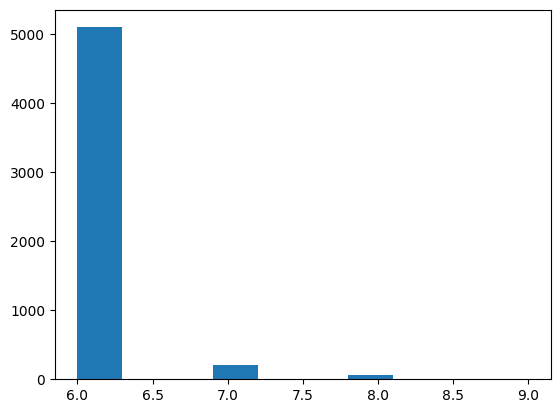

In [9]:
# Build per-jet mask (jagged)
for event in range(NUM_EVENTS):
    event_mask = np.abs(GenJet_hadronFlavour[event]) == 5

    # Apply mask to all jet-level arrays
    GenJet_pt[event] = GenJet_pt[event][event_mask]
    GenJet_eta[event] = GenJet_eta[event][event_mask]
    GenJet_phi[event] = GenJet_phi[event][event_mask]
    GenJet_mass[event] = GenJet_mass[event][event_mask]
    
    GenJet_partonFlavour[event] = GenJet_partonFlavour[event][event_mask]
    GenJet_hadronFlavour[event] = GenJet_hadronFlavour[event][event_mask]

nGenJet = np.array([len(event) for event in GenJet_pt])

print(f'Min: {np.min(nGenJet)}')
print(f'Max: {np.max(nGenJet)}')
print(f'Mean: {np.mean(nGenJet)}')
print(f'Std: {np.std(nGenJet)}')
plt.hist(nGenJet)

### (Optional) Keep Only 6 b-jet Events

Technically, QUBO approach works on N > 6 b-jet events. But if we, for any reason, want to use only events with N = 6, uncomment the cell bellow.

In [10]:
'''
exact6_mask = np.ones(NUM_EVENTS, dtype=bool)
exact6_mask[nGenJet!=6] = False

nGenJet = nGenJet[event][exact6_mask]

GenJet_pt = GenJet_pt[exact6_mask]
GenJet_eta = GenJet_eta[exact6_mask]
GenJet_phi = GenJet_phi[exact6_mask]
GenJet_mass = GenJet_mass[exact6_mask]

GenJet_partonFlavour = GenJet_partonFlavour[exact6_mask]
GenJet_hadronFlavour = GenJet_hadronFlavour[exact6_mask]

nGenPart = nGenPart[exact6_mask]

GenPart_pt = GenPart_pt[exact6_mask]
GenPart_eta = GenPart_eta[exact6_mask]
GenPart_phi = GenPart_phi[exact6_mask]
GenPart_mass = GenPart_mass[exact6_mask]

GenPart_pdgId = GenPart_pdgId[exact6_mask]
GenPart_genPartIdxMother = GenPart_genPartIdxMother[exact6_mask]
GenPart_status = GenPart_status[exact6_mask]
GenPart_statusFlags = GenPart_statusFlags[exact6_mask]

NUM_EVENTS = len(nGenJet)   # We now update global variable to match the new number of events
'''

'\nexact6_mask = np.ones(NUM_EVENTS, dtype=bool)\nexact6_mask[nGenJet!=6] = False\n\nnGenJet = nGenJet[event][exact6_mask]\n\nGenJet_pt = GenJet_pt[exact6_mask]\nGenJet_eta = GenJet_eta[exact6_mask]\nGenJet_phi = GenJet_phi[exact6_mask]\nGenJet_mass = GenJet_mass[exact6_mask]\n\nGenJet_partonFlavour = GenJet_partonFlavour[exact6_mask]\nGenJet_hadronFlavour = GenJet_hadronFlavour[exact6_mask]\n\nnGenPart = nGenPart[exact6_mask]\n\nGenPart_pt = GenPart_pt[exact6_mask]\nGenPart_eta = GenPart_eta[exact6_mask]\nGenPart_phi = GenPart_phi[exact6_mask]\nGenPart_mass = GenPart_mass[exact6_mask]\n\nGenPart_pdgId = GenPart_pdgId[exact6_mask]\nGenPart_genPartIdxMother = GenPart_genPartIdxMother[exact6_mask]\nGenPart_status = GenPart_status[exact6_mask]\nGenPart_statusFlags = GenPart_statusFlags[exact6_mask]\n\nNUM_EVENTS = len(nGenJet)   # We now update global variable to match the new number of events\n'

### Sort Jets by pt

We usually want to sort b-tagged jets in event by pt in descending order, so that jet_1 in each event has the highest pt.

In [11]:
# Get sorting indices per event (descending pt)
order = [np.argsort(row)[::-1] for row in GenJet_pt]

# Apply same ordering to all branches
GenJet_pt            = np.array([row[o] for row, o in zip(GenJet_pt, order)], dtype=object)
GenJet_eta           = np.array([row[o] for row, o in zip(GenJet_eta, order)], dtype=object)
GenJet_phi           = np.array([row[o] for row, o in zip(GenJet_phi, order)], dtype=object)
GenJet_mass          = np.array([row[o] for row, o in zip(GenJet_mass, order)], dtype=object)
GenJet_partonFlavour = np.array([row[o] for row, o in zip(GenJet_partonFlavour, order)], dtype=object)
GenJet_hadronFlavour = np.array([row[o] for row, o in zip(GenJet_hadronFlavour, order)], dtype=object)

# QUBO Dataframes
We are now going to use our dataframes to create variables needed for QUBO/BQM building

## Pair Variables

Our QUBO/BQM for jet-assignment does not use binary tuples `y_ij = (jet_i, jet_j)` as variables for pairing jets. Instead, we create all unique pairs, and treat each pair as a single binary object `x_i` representing which pair should be picked. 

For example, 6 jets can make 15 unique pairs:

{'0': (0, 1),
 '1': (0, 2),
 '2': (0, 3),
 '3': (0, 4),
 '4': (0, 5),
 '5': (1, 2),
 '6': (1, 3),
 '7': (1, 4),
 '8': (1, 5),
 '9': (2, 3),
 '10': (2, 4),
 '11': (2, 5),
 '12': (3, 4),
 '13': (3, 5),
 '14': (4, 5)}

 This is why we need to calculate properties for each pair.

 *Hint: use `map = create_pair_mapping(num_jets)` to create mapping dictionary for any number of jets.*

In [12]:
example_map = create_pair_mapping(6)
print(example_map)

{'0': (0, 1), '1': (0, 2), '2': (0, 3), '3': (0, 4), '4': (0, 5), '5': (1, 2), '6': (1, 3), '7': (1, 4), '8': (1, 5), '9': (2, 3), '10': (2, 4), '11': (2, 5), '12': (3, 4), '13': (3, 5), '14': (4, 5)}


### Number of Pairs (nPairs)

In [13]:
nPairs = np.array([])
for event in range(NUM_EVENTS):
    nPairs = np.append(nPairs, len(create_pair_mapping(nGenJet[event])))

print(nGenJet[:10])
print(nPairs[:10])

[6 6 6 7 6 6 6 6 6 6]
[15. 15. 15. 21. 15. 15. 15. 15. 15. 15.]


### Pair Invariant Masses (Pair_mass)

### Pair Angular Separation (Pair_delR)

### Pair pt-Balance (Pair_ptBalance)

### Pair Transverse Momentum (Pair_pt)

### Pair Pseudorapidity (Pair_eta)